In [1]:
#filename = '/var/kat/archive/data/comm/2014/05/01/1398974314.h5'
filename="/var/kat/archive/data/comm/2016/06/22/1466634614.h5"


In [2]:
#!/usr/bin/env python
import katfile
import numpy as np
import os
import textwrap
import time
%pylab inline
from pylab import axes, figure, legend, plot,plt, savefig, sys, text, title,xlabel, xticks, ylabel, ylim, yticks
from matplotlib.ticker import AutoMinorLocator


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py:187: RuntimeWarning: You have iterated over the result of pkg_resources.parse_version. This is a legacy behavior which is inconsistent with the new version class introduced in setuptools 8.0. In most cases, conversion to a tuple is unnecessary. For comparison of versions, sort the Version instances directly. If you have another use case requiring the tuple, please file a bug with the setuptools project describing that need.
  stacklevel=1,


In [3]:
def make_frontpage(file_ptr):
    if float(file_ptr.version) >= 2.0:
        instruction_set = file_ptr.file['MetaData']['Configuration']['Observation'].attrs.items()
        instruction_set = ' '.join((instruction_set[1][1], instruction_set[2][1]))
    else:
        instruction_set = 'Unknown'

    scp='Instruction_set : %s' % (instruction_set,)
    scp='\n'.join(textwrap.wrap(scp, 126)) #add new line after every 126 charecters
    scp='\n'+scp+'\n' #add space before and after instruction set

    mystring_seperated=str(file_ptr).split('\n')

    startdate = time.strftime('%d %b %y', time.localtime(file_ptr.start_time))

    lststart=("%2.0f:%2.0f"%(np.modf(file_ptr.lst[0])[1], np.modf(file_ptr.lst[0])[0]*60))
    lststop=("%2.0f:%2.0f"%(np.modf(file_ptr.lst[len(file_ptr.lst)-1])[1], np.modf(file_ptr.lst[len(file_ptr.lst)-1])[0]*60))

    frontpage = []
    frontpage.append('Description: %s' % (file_ptr.description,))
    frontpage.append('Name: %s' % (file_ptr.name,))
    frontpage.append('Experiment ID: %s' % (file_ptr.experiment_id,))
    frontpage.append(scp)
    frontpage.append('Observer: %s' % (file_ptr.observer,))
    frontpage.append(mystring_seperated[5])
    frontpage.append('Observed on: %s from %s LST to %s LST' % (startdate, lststart, lststop))
    frontpage.append('\n')
    frontpage.append('Dump rate / period: %s Hz / %s s' % (str((round(1/file_ptr.dump_period,6))), str(round(file_ptr.dump_period,4))))
    frontpage.append(mystring_seperated[7])
    frontpage.append(mystring_seperated[8])
    frontpage.append(mystring_seperated[9])
    frontpage.append('Number of Dumps: %s' % (str(file_ptr.shape[0])))
    frontpage.append('\n')
    frontpage.append(mystring_seperated[11])
    frontpage.append(mystring_seperated[12])
    frontpage.append(mystring_seperated[21])
    frontpage.append('\n')
    return '\n'.join(frontpage)


In [4]:

def plot_time_series(ants,pol,count,startime):
    #Time Series
    figure(figsize=(13,10), facecolor='w', edgecolor='k')
    xlabel("LST on "+starttime,fontweight="bold")
    ylabel("Amplitude",fontweight="bold")
    for ant in ants:
        print ("plotting "+ant.name+"_" +pol+pol+ " time series")
        f.select(ants=ant,corrprods='auto',pol=pol)
        if len(f.channels)<1025:
            f.select(channels=range(200,800))
        if count==0:
            plot(f.lst,10*np.log10(mean(abs(f.vis[:]),1)),label=(ant.name+'_'+pol+pol))
            locs,labels=xticks()
            for i in range(len(locs)):
                labels[i]=("%2.0f:%2.0f"%(np.modf(locs[i])[1], np.modf(locs[i])[0]*60))
            xticks(locs,labels)
        elif count==1:
            plot(f.lst,10*np.log10(mean(abs(f.vis[:]),1)),label=(ant.name+'_'+pol+pol))
            locs,labels=xticks()
            for i in range(len(locs)):
                labels[i]=("%2.0f:%2.0f"%(np.modf(locs[i])[1], np.modf(locs[i])[0]*60))
            xticks(locs,labels)
      
    legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, fancybox=True, shadow=False)



In [5]:
def plot_spectrum(pol, datafile, starttime, ant):
    #Spectrum function
    fig=figure(figsize=(13,10), facecolor='w', edgecolor='k')
    ab = []
    for  count in (0,1):
        ab.append(fig.add_subplot(2,1,(count+1)))
        ab[-1].set_ylim(2,16)
        if len(f.channels)<1025:
            ab[-1].set_xlim(195,805)
        else:
            ab[-1].set_xlim(0,len(f.channels))
        ab[-1].set_xlabel("Channels", fontweight="bold")
        ab[-1].set_ylabel("Amplitude", fontweight="bold")
        f.select(ants=ant,corrprods='auto',pol=pol[count])
        abs_vis=np.abs(f.vis[:])
        if (10*np.log10((abs_vis.max(axis=0)).max())) >16:
            ab[-1].set_ylim(2,ymax=0.5+(10*np.log10((abs_vis.max(axis=0)).max())))
        label_format = '%s_%s%s' % (ant.name, pol[count], pol[count])
        #print "Starting to plot the %s spectrum." % (label_format,)
        plotcolours=['g','b','m']
        colours=0
        for stat in ('mean', 'min', 'max'):
            ab[-1].plot(f.channels, 10*np.log10(getattr(abs_vis,stat)(axis=0)), label=('%s_%s' % (label_format, stat)),color=plotcolours[colours] )
            colours+=1
        ab[-1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, fancybox=True, shadow=False)
        minorLocator   = AutoMinorLocator()
        ab[-1].xaxis.set_minor_locator(minorLocator)
        tick_params(which='both', color='k')
        tick_params(which='major', length=6,width=2)
        tick_params(which='minor', width=1,length=4)

        ab.append(ab[-1].twinx())
        flag=f.flags()[:]
        # total_sum=0
        perc=[]
        for i in range(len(f.channels)):
            f_chan=flag[:,i,0].squeeze()
            suming=f_chan.sum()
            perc.append(100*(suming/float(f_chan.size)))
        ab[-1].bar(f.channels,perc,color='r',edgecolor='none')
        minorLocator   = AutoMinorLocator()
        ab[-1].xaxis.set_minor_locator(minorLocator)
        ab[-1].set_ylabel("% flagged", fontweight="bold")
        ab[-1].set_ylim(0,100)
        if len(f.channels)<1025:
            ab[-1].set_xlim(195,805)
        else:
            ab[-1].set_xlim(0,len(f.channels))

In [6]:

def plot_envioronmental_sensors(f):
    print "Getting wind and temperature sensors"
    fig=figure(figsize=(13,10))
    ax1 = fig.add_subplot(211)
    ax1.plot(f.lst,f.sensor['Enviro/asc.air.temperature'],'g-')
    airtemp=f.sensor['Enviro/asc.air.temperature']
    ylim(ymin=-1,ymax=35)
    mintemp=min(airtemp)
    maxtemp=max(airtemp)
    if maxtemp>=35:
        ylim(ymax=(maxtemp+1))
    if mintemp<=(-1.0):
        ylim(ymin=(mintemp-1))
    locs,labels=xticks()
    for i in range(len(locs)):
        labels[i]=("%2.0f:%2.0f"%(np.modf(locs[i])[1], np.modf(locs[i])[0]*60))
    xticks(locs,labels)
    ax1.grid(axis='y', linewidth=0.15, linestyle='-', color='k')
    ax1.set_xlabel("LST on "+starttime, fontweight="bold")
    ax1.set_ylabel('Temperature (Deg C)', color='g',fontweight="bold")
    for tl in ax1.get_yticklabels():
        tl.set_color('g')

    #Relative to Absolute
    rh=f.sensor['Enviro/asc.air.relative-humidity']
    t=f.sensor['Enviro/asc.air.temperature']
    Pws=[]
    Pw=[]
    ah=[]
    for m in range(len(rh)):
        Pws.append(6.1162*(10**((7.5892*t[m])/(t[m]+240.71))))
    for m in range(len(rh)):
        Pw.append(Pws[m]*(rh[m]/100))
    for m in range(len(rh)):
        ah.append(2.11679*((Pw[m]*100)/(273.16+t[m])))

    ax2=ax1.twinx()
    ax2.plot(f.lst,ah,'c-')
    ylim(ymin=1,ymax=8)
    minah=min(ah)
    maxah=max(ah)
    if maxah>=8:
        ylim(ymax=(maxah+1))
    if minah<=(1.0):
        ylim(ymin=(minah-1))
    locs,labels=xticks()
    ax2.grid(axis='y', linewidth=0.15, linestyle='-', color='k')
    ax2.set_ylabel('Absolute Humidity g/m^3', fontweight="bold",color='c')
    for tl in ax2.get_yticklabels():
        tl.set_color('c')

    ax3=fig.add_subplot(212)
    ax3.grid(axis='y', linewidth=0.15, linestyle='-', color='k')
    ax3.plot(f.lst ,((f.sensor['Enviro/asc.air.pressure'])/10),'r-')
    airpress=f.sensor['Enviro/asc.air.pressure']/10
    ylim(ymin=87,ymax=92)
    minairpress=min(airpress)
    maxairpress=max(airpress)
    if maxairpress>=92:
       ylim(ymax=(maxairpress+1))
    if minairpress<=87:
        ylim(ymin=(minairpress-1))
    for i in range(len(locs)):
        labels[i]=("%2.0f:%2.0f"%(np.modf(locs[i])[1], np.modf(locs[i])[0]*60))
    xticks(locs,labels)
    ax3.grid(axis='y', linewidth=0.15, linestyle='-', color='k')
    ax3.set_ylabel('Air Pressure (kPa)', fontweight="bold",color='r')
    for tl in ax3.get_yticklabels():
        tl.set_color('r')
    ax4=ax3.twinx()
    ax4.plot(f.lst,f.sensor['Enviro/asc.wind.speed'],'b-')
    wspeed=f.sensor['Enviro/asc.wind.speed']
    ylim(ymin=-0.5,ymax=16)
    minwind=min(wspeed)
    maxwind=max(wspeed)
    if maxwind>=16:
        ylim(ymax=(maxwind+1))
    if minwind<=-0.5:
        ylim(ymin=(minwind-1))
    ax4.set_xlabel("LST on "+starttime,fontweight="bold")
    ax4.set_ylabel('Wind Speed (m/s)',fontweight="bold", color='b')
    for tl in ax4.get_yticklabels():
        tl.set_color('b')

In [7]:
def plot_bpcal_selection(f):
    fig = plt.figure(figsize=(21,15))
    try:
        for pol in ('h','v'):
            f.select(targets=f.catalogue.filter(tags='bpcal'), corrprods='cross', pol=pol, scans='track')
            crosscorr = [(f.inputs.index(inpA), f.inputs.index(inpB)) for inpA, inpB in f.corr_products]
            #extract the fringes
            fringes = np.angle(f.vis[:,:,:])
            #For plotting the fringes
            fig.subplots_adjust(wspace=0., hspace=0.)
            #debug_here()
            for n, (indexA, indexB) in enumerate(crosscorr):
                subplot_index = (len(f.ants) * indexA + indexB + 1) if pol == 'h' else (indexA + len(f.ants) * indexB + 1)
                ax = fig.add_subplot(len(f.ants), len(f.ants), subplot_index)
                ax.imshow(fringes[:,:,n],aspect=fringes.shape[1]/fringes.shape[0])
                ax.set_xticks([])
                ax.set_yticks([])
                if pol == 'h':
                    if indexA == 0:
                        ax.xaxis.set_label_position('top')
                        ax.set_xlabel(f.inputs[indexB][3:],size='xx-large')
                    if indexB == len(f.ants) - 1:
                       ax.yaxis.set_label_position('right')
                       ax.set_ylabel(f.inputs[indexA][3:], rotation='horizontal',size = 'xx-large')
                else:
                    if indexA == 0:
                        ax.set_ylabel(f.inputs[indexB][3:], rotation='horizontal',size='xx-large')
                    if indexB == len(f.ants) - 1:
                        ax.set_xlabel(f.inputs[indexA][3:],size='xx-large')

    except KeyError, error:
            print 'Failed to read scans from File: %s with Key Error: %s' % (f, error)
    except ValueError, error:
            print 'Failed to read scans from File: %s with Value Error: %s' % (f, error)

In [8]:
def plot_target_selection(f):
    fig = plt.figure(figsize=(21,15))
    try:
        for pol in ('h','v'):
            f.select(targets=f.catalogue.filter(tags='target'), corrprods='cross', pol=pol, scans='track')
            crosscorr = [(f.inputs.index(inpA), f.inputs.index(inpB)) for inpA, inpB in f.corr_products]
            #extract the fringes
            power = 10 * np.log10(np.abs((f.vis[:,:,:])))
            #For plotting the fringes
            fig.subplots_adjust(wspace=0., hspace=0.)
            #debug_here()
            for n, (indexA, indexB) in enumerate(crosscorr):
                subplot_index = (len(f.ants) * indexA + indexB + 1) if pol == 'h' else (indexA + len(f.ants) * indexB + 1)
                ax = fig.add_subplot(len(f.ants), len(f.ants), subplot_index)
                ax.plot(f.channel_freqs,np.mean(power[:,:,n],0))
                ax.set_xticks([])
                ax.set_yticks([])
                if pol == 'h':
                    if indexA == 0:
                        ax.xaxis.set_label_position('top')
                        ax.set_xlabel(f.inputs[indexB][3:],size='xx-large')
                    if indexB == len(f.ants) - 1:
                        ax.yaxis.set_label_position('right')
                        ax.set_ylabel(f.inputs[indexA][3:], rotation='horizontal',size = 'xx-large')
                else:
                    if indexA == 0:
                        ax.set_ylabel(f.inputs[indexB][3:], rotation='horizontal',size='xx-large')
                    if indexB == len(f.ants) - 1:
                        ax.set_xlabel(f.inputs[indexA][3:],size='xx-large')
            #plt.savefig(pp,format='pdf')
    except KeyError , error:
        print 'Failed to read scans from File: ',f, ' with Key Error:',error
    except ValueError , error:
        print 'Failed to read scans from File: ',f,' with Value Error:',error

################################################################################


In [9]:
d = filename

print "Opening %s using katfile, this might take a while" % (d,)
f=katfile.open(d, quicklook=True)

Opening /var/kat/archive/data/comm/2016/06/22/1466634614.h5 using katfile, this might take a while


/usr/local/lib/python2.7/dist-packages/katfile/categorical.py:534: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1478 but corresponding boolean dimension is 1477
  sensor_values, events = sensor_values[non_empty], np.r_[events[non_empty], len(dump_midtimes)]
/usr/local/lib/python2.7/dist-packages/katfile/categorical.py:534: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 1
  sensor_values, events = sensor_values[non_empty], np.r_[events[non_empty], len(dump_midtimes)]
/usr/local/lib/python2.7/dist-packages/katfile/categorical.py:534: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 52 but corresponding boolean dimension is 51
  sensor_values, events = sensor_values[non_empty], np.r_[events[non_empty], len(dump_midtimes)]
/usr/local/lib/python2.7/dist-packages/katfile/categorical.py:534: V

Name: /var/kat/archive/data/comm/2016/06/22/1466634614.h5 (version 2.1)
Observer: Nadeem  Experiment ID: 20160622-0009
Description: 'W2332 Low'
Observed from 2016-06-23 00:30:26.482 SAST to 2016-06-23 04:36:36.686 SAST
Dump rate / period: 0.10000 Hz / 10.000 s
Subarrays: 1
  ID  Antennas                            Inputs  Corrprods
   0  ant1,ant2,ant3,ant5,ant6            10       60
Spectral Windows: 1
  ID  Mode       CentreFreq(MHz)  Bandwidth(MHz)  Channels  ChannelWidth(kHz)
   0  bc16n400M1k 1328.000         400.000          1024      390.625
-------------------------------------------------------------------------------
Data selected according to the following criteria:
  subarray=0
  ants=['ant5', 'ant6', 'ant1', 'ant3', 'ant2']
  spw=0
-------------------------------------------------------------------------------
Shape: (1477 dumps, 1024 channels, 60 correlation products) => Size: 725.975 MB
Antennas: ant1,ant2,ant3,*ant5,ant6  Inputs: 10  Autocorr: yes  Crosscorr: yes
Chann

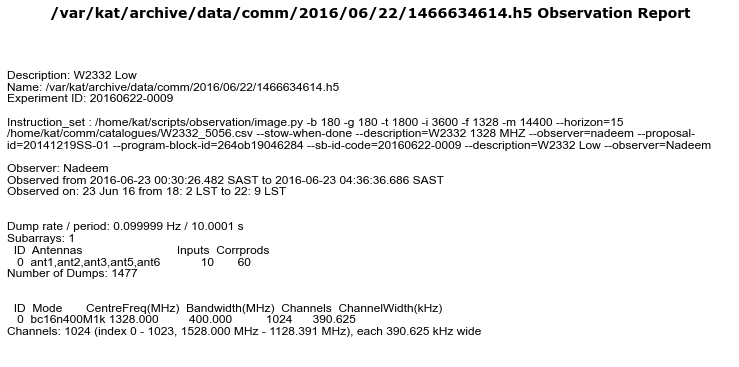

In [10]:
#start a figure
figure(figsize = (13,6))
axes(frame_on=False)
xticks([])
yticks([])
title(d+" Observation Report",fontsize=14, fontweight="bold")

frontpage = make_frontpage(f)
text(0,0,frontpage,fontsize=12)
print f

plotting ant1_hh time series
plotting ant2_hh time series
plotting ant3_hh time series
plotting ant5_hh time series
plotting ant6_hh time series
plotting ant1_vv time series
plotting ant2_vv time series
plotting ant3_vv time series
plotting ant5_vv time series
plotting ant6_vv time series


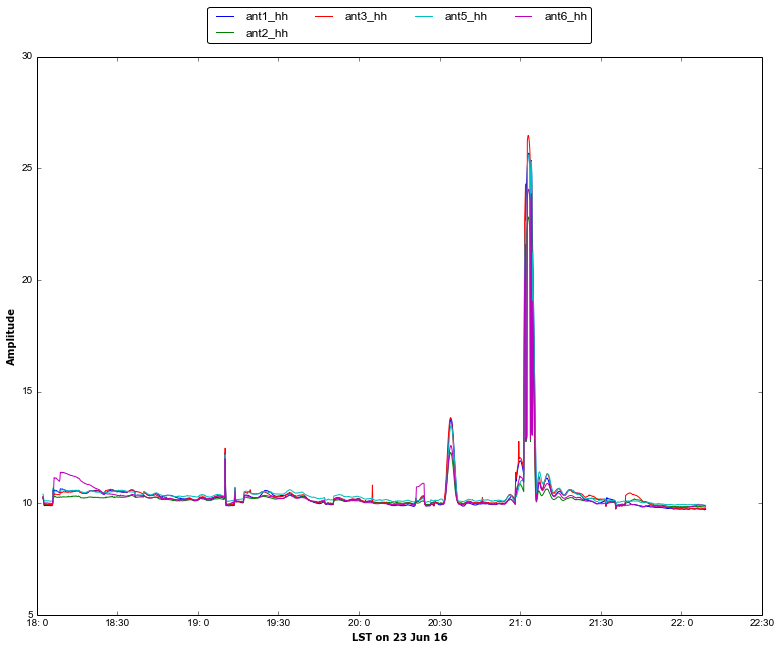

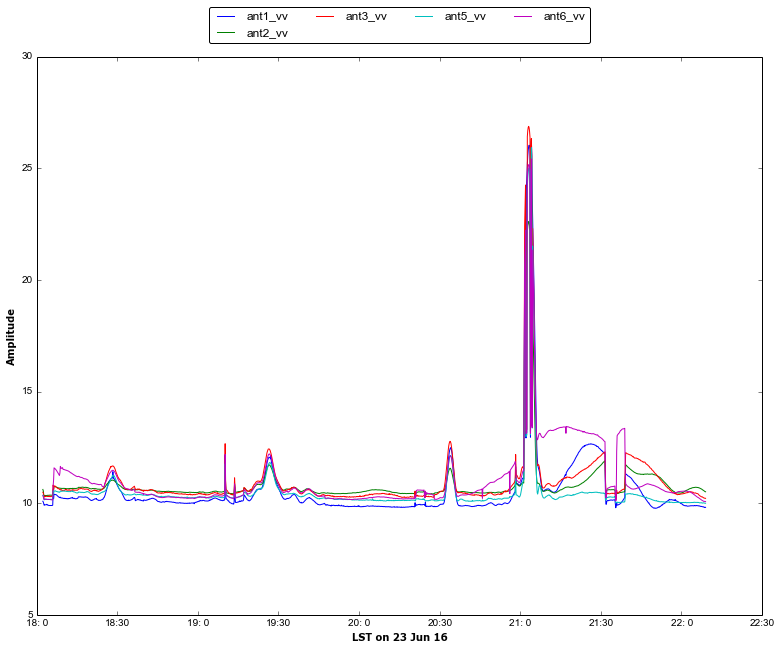

In [11]:
count=0
ants=f.ants
pol=['h','v']
starttime = time.strftime('%d %b %y', time.localtime(f.start_time))
plot_time_series(ants, pol[0], count, starttime)
count=count+1
plot_time_series(ants, pol[1], count, starttime)

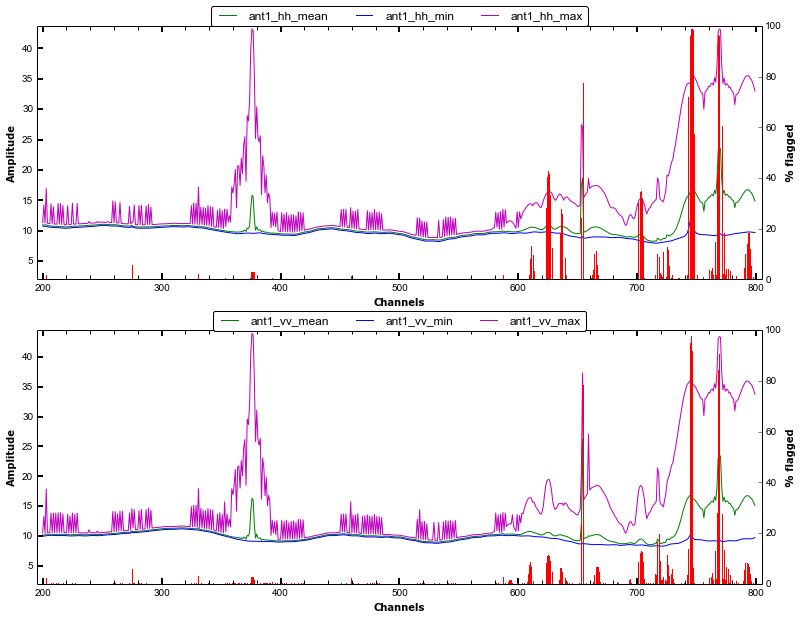

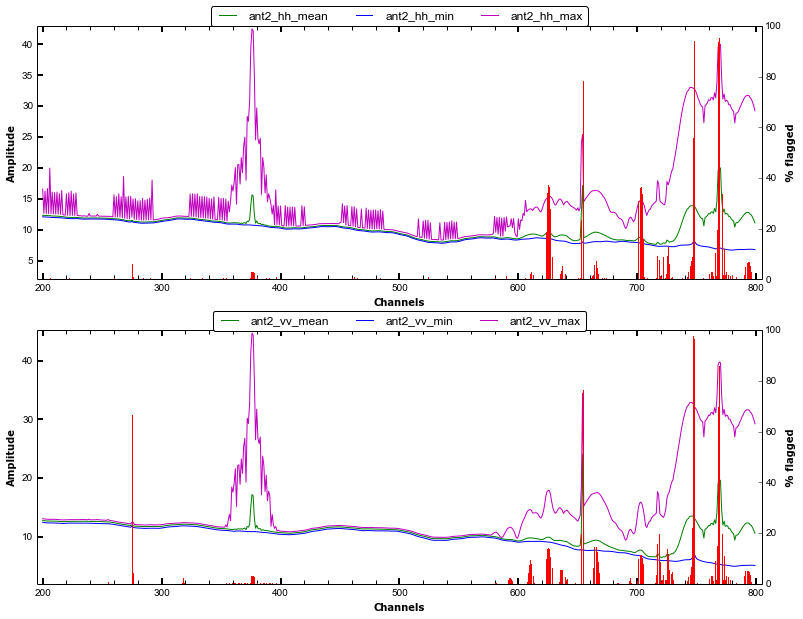

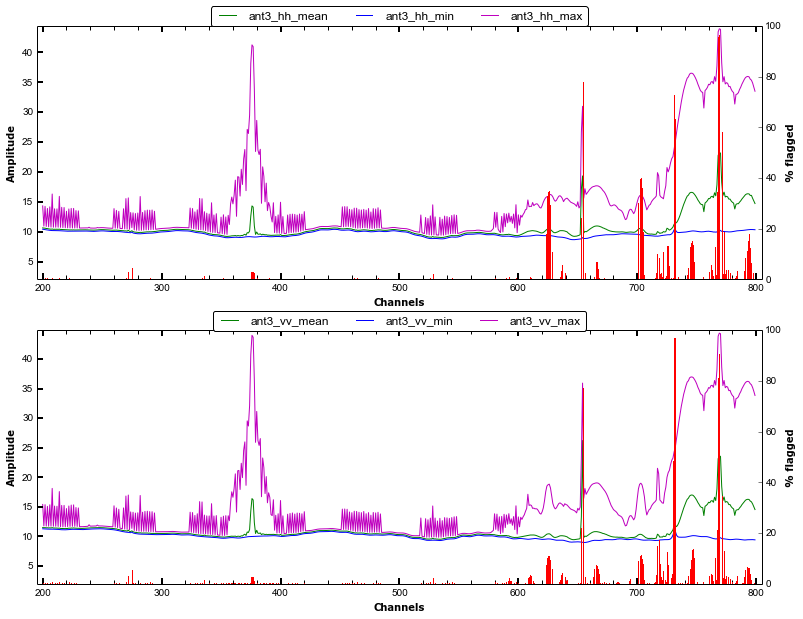

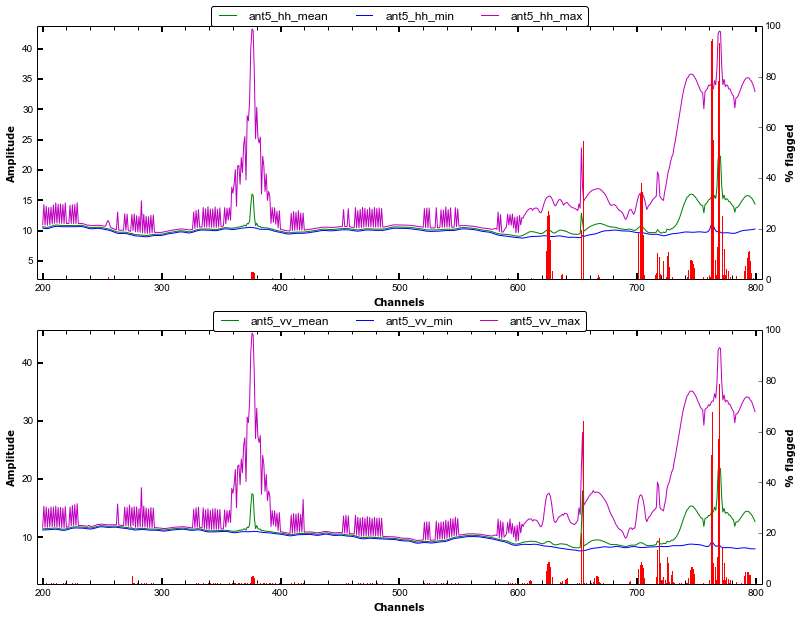

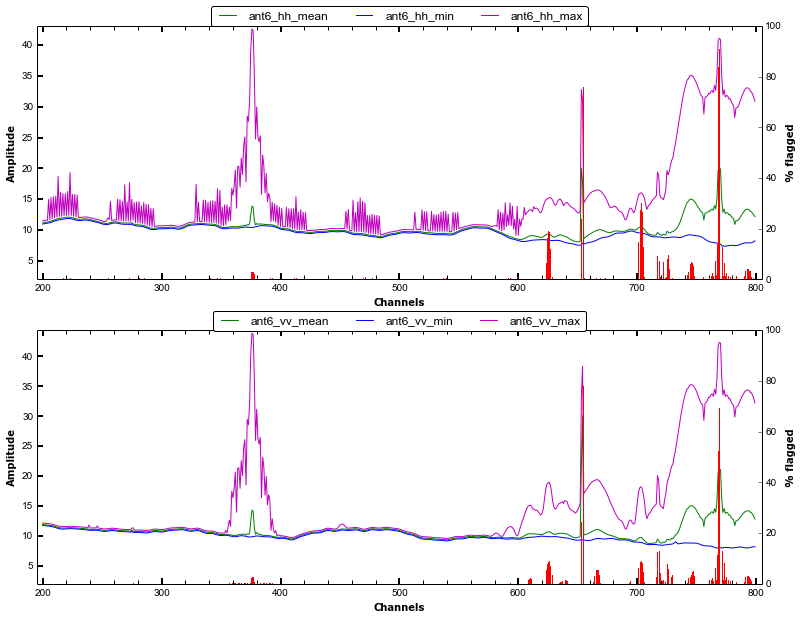

In [12]:
for ant in ants:
    plot_spectrum(pol,d,starttime,ant)

Getting wind and temperature sensors


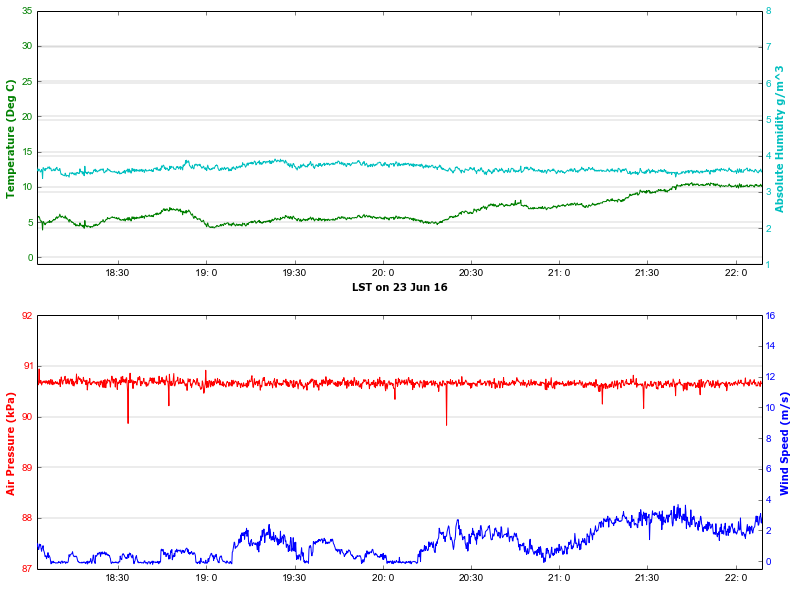

In [13]:
plot_envioronmental_sensors(f)

Plotting bpcal fringes.


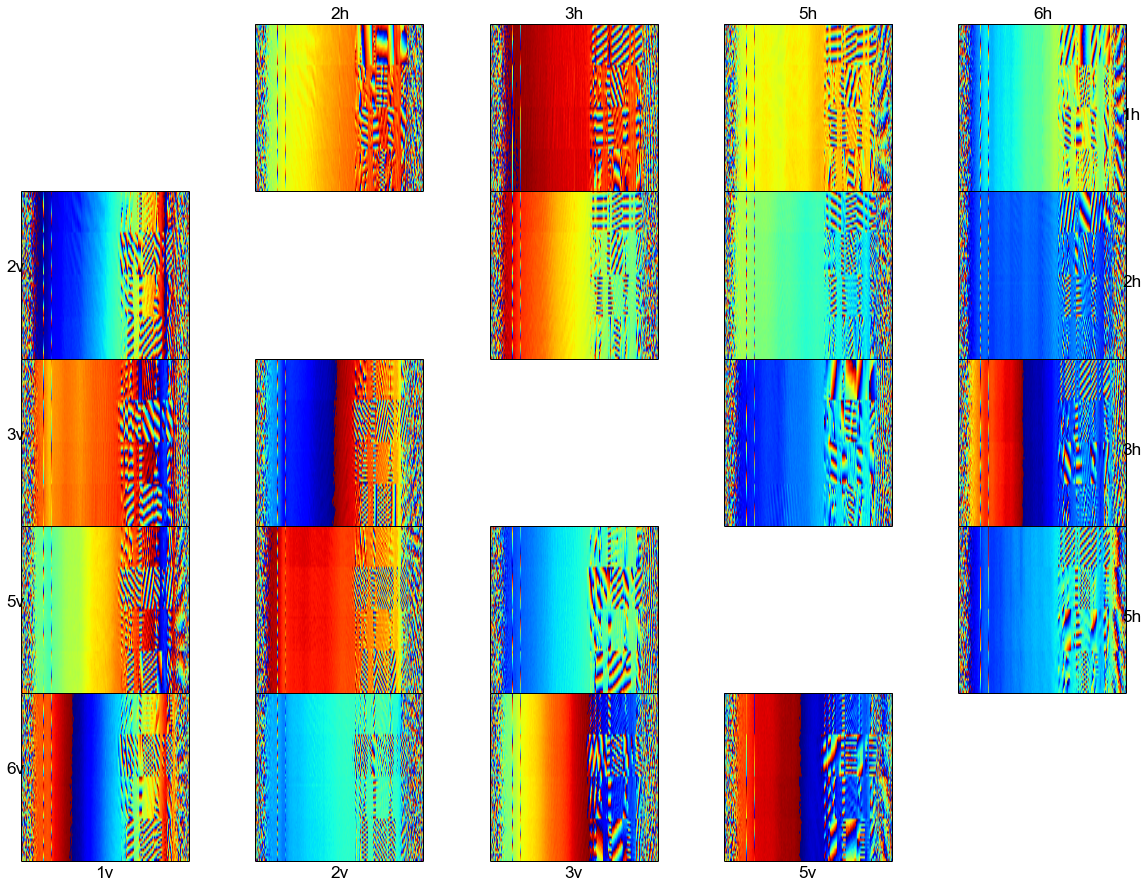

In [14]:
f.select()
if f.catalogue.filter(tags='bpcal'):
    print "Plotting bpcal fringes."
    plot_bpcal_selection(f)
else:
    print "No bpcal tags found in catalog, we wont plot bpcal fringes."

Plotting target correlation spectra.


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10


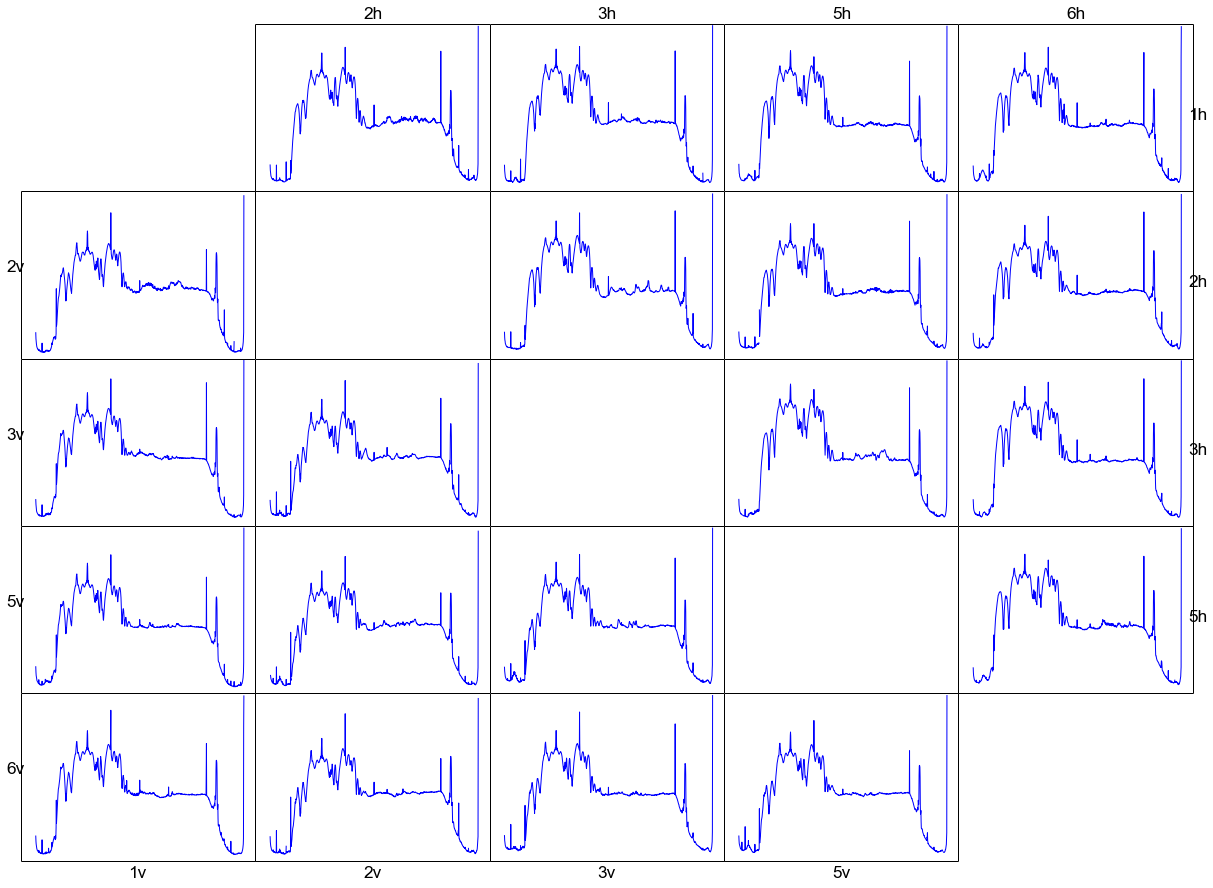

In [15]:
if f.catalogue.filter(tags='target'):
    print "Plotting target correlation spectra."
    plot_target_selection(f)
else:
    print "No target tags found in catalog, we wont plot the target cross correlation spectra."